# HW_3
### Задача: используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

### Шаг 1. Загрузки и преобразование исходных данных. Подготовка датасета для дальнейшего анализа.

In [23]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_DIR = Path.cwd()

In [2]:
# Запишем исходные данные в DataFrames
file_path = BASE_DIR.parent

lec_data = pd.read_csv(f'{file_path}/Исходные датасеты/hw_3/lectures.csv', sep=',')
ques_data = pd.read_csv(f'{file_path}/Исходные датасеты/hw_3/questions.csv', sep=',')
train_data = pd.read_csv(f'{file_path}/Исходные датасеты/hw_3/train.csv', sep=',')


In [3]:
# Чтобы не "побить" первоначальный датасет будем работать с его копией.
lec_df = lec_data.copy()
ques_df = ques_data.copy()
train_df = train_data.copy()

In [4]:
# Посмотрим на тип данных, для того, чтобы понять, по каким столбцам можно/нужно сделать преобразования.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 7.5+ GB


In [5]:
# Преобразуем типы данных, чтобы уменьшить объем данных:
train_df['user_id'] = train_df['user_id'].astype('int32')
train_df['content_id'] = train_df['content_id'].astype('int16')
train_df['content_type_id'] = train_df['content_type_id'].astype('int8')
train_df['task_container_id'] = train_df['task_container_id'].astype('int16')
train_df['user_answer'] = train_df['user_answer'].astype('int8')
train_df['answered_correctly'] = train_df['answered_correctly'].astype('int8')
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].astype('float32')
train_df['prior_question_had_explanation'] = train_df['prior_question_had_explanation'].astype('bool')

# удалим столбец из-за его бесполезности (c преобразованием датасета)
train_df.drop(['row_id'], axis=1, inplace=True) 

# проверим изменения и самое главное сверим размер данных (memory usage)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   user_answer                     int8   
 6   answered_correctly              int8   
 7   prior_question_elapsed_time     float32
 8   prior_question_had_explanation  bool   
dtypes: bool(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 2.3 GB


In [6]:
# Проверим на наличие пропусков в каждом столбце
missing_values = train_df.isnull().sum()
print(missing_values)

timestamp                               0
user_id                                 0
content_id                              0
content_type_id                         0
task_container_id                       0
user_answer                             0
answered_correctly                      0
prior_question_elapsed_time       2351538
prior_question_had_explanation          0
dtype: int64


In [7]:
# Пропусков не так уж и много, к тому же они обусловлены условием задачи - 
# это только null для первого пакета вопросов или лекции пользователя.
# Поэтому можно было бы выбрать любой из вариантов (удалить, заполнить медианой, 
# фильтровать при дальнейшем анализе при использовании данного столбца)
# и он не повлиял бы на результаты анализа.
# В данном случае выберем заполнить пропуски в столбце prior_question_elapsed_time медианой
train_df['prior_question_elapsed_time'] = train_df['prior_question_elapsed_time'].fillna(train_df['prior_question_elapsed_time'].median())

In [42]:
# Проверим еще раз, что пустых значений теперь в данных нет
missing_values = train_df.isnull().sum()
print(missing_values)

timestamp                         0
user_id                           0
content_id                        0
content_type_id                   0
task_container_id                 0
user_answer                       0
answered_correctly                0
prior_question_elapsed_time       0
prior_question_had_explanation    0
dtype: int64


In [9]:
# Для дальнейшей работы возьмем 10% случайных данных из общей выборки
sample_df = train_df.sample(frac=0.1, random_state=42)
print(f'Размер выборки: {sample_df.shape[0]} строк.')


Размер выборки: 10123033 строк.


### Шаг 2. Анализ характеристик и визуализация результата
##### <u>1. Процент правильных ответов по разделам теста (part):</u>

In [10]:
# Соединяем таблицу вопросов с train_df по content_id, для вопросов (content_type_id == 0)
questions_train = pd.merge(
    sample_df[sample_df['content_type_id'] == 0], 
    ques_df[['question_id', 'part']], 
    left_on='content_id', 
    right_on='question_id', 
    how='left'
)

# Группируем по разделу (part) и считаем средний процент правильных ответов
part_correct = questions_train.groupby('part')['answered_correctly'].mean()

# Выведем результат
print(part_correct)


part
1    0.745914
2    0.708941
3    0.701569
4    0.630774
5    0.610434
6    0.669473
7    0.660337
Name: answered_correctly, dtype: float64


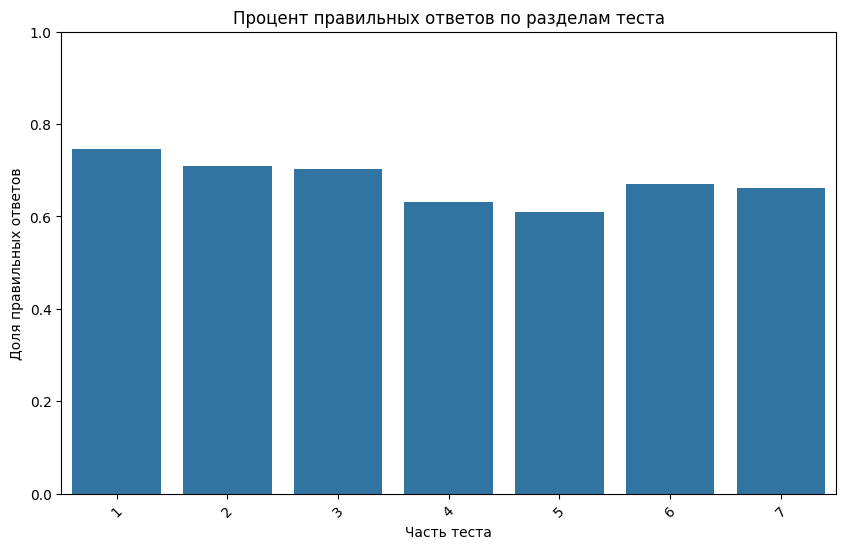

In [24]:
# Визуализация процента правильных ответов по разделам теста
plt.figure(figsize=(10, 6))
sns.barplot(x=part_correct.index, y=part_correct.values)
plt.title('Процент правильных ответов по разделам теста')
plt.xlabel('Часть теста')
plt.ylabel('Доля правильных ответов')
plt.xticks(rotation=45)
plt.ylim(0, 1)  # Ограничиваем ось Y от 0 до 1
plt.show()

<u>Вывод:</u> Из результатов анализа процента правильных ответов по разделам теста, можно увидеть, что в среднем, чем выше номер раздела теста, тем он сложнее по своим вопросам, т.е. количество правильных ответов снижается, хоть и незначительно.

##### <u>2. Влияние лекций и объяснений на успеваемость:</u>

In [11]:
# Посмотрим процент правильных ответов для пользователей, которые видели объяснение/лекции и для тех кто лекции не смотрел
explanation_correct = sample_df.groupby('prior_question_had_explanation')['answered_correctly'].mean()

# Выведем результат
print(explanation_correct)


prior_question_had_explanation
False    0.237446
True     0.673514
Name: answered_correctly, dtype: float64


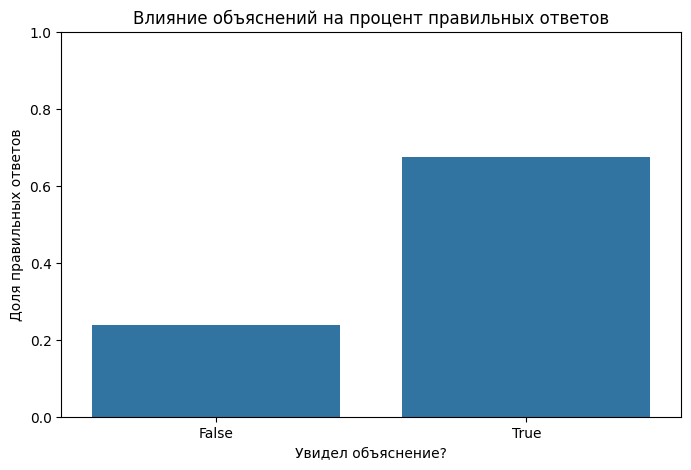

In [25]:
# Визуализация влияния лекций и объяснений на успеваемость
plt.figure(figsize=(8, 5))
sns.barplot(x=explanation_correct.index, y=explanation_correct.values)
plt.title('Влияние объяснений на процент правильных ответов')
plt.xlabel('Увидел объяснение?')
plt.ylabel('Доля правильных ответов')
plt.ylim(0, 1)  # Ограничиваем ось Y от 0 до 1
plt.show()

<u>Вывод:</u> Видно явную зависимость между просмотром студентами лекций и их успеваемостью.

##### <u>3. Влияние времени на ответ на успеваемость:</u>

In [12]:
# Посмотрим, как распределяются данные по времени на ответ в наших данных, 
# чтобы определить категории для классификации и анализа
sample_df['prior_question_elapsed_time'].describe()


count    1.012303e+07
mean     2.532300e+04
std      1.972599e+04
min      0.000000e+00
25%      1.600000e+04
50%      2.100000e+04
75%      2.900000e+04
max      3.000000e+05
Name: prior_question_elapsed_time, dtype: float64

Исходя из распределения, можно создать следующие категории:
1.	Меньше 5 секунд (0 - 5000 мс) — очень быстрое время, возможно, интуитивные или случайные ответы.
2.	5 - 15 секунд (5000 - 15000 мс) — достаточно быстрое время, чаще всего встречающееся в тестах.
3.	15 - 25 секунд (15000 - 25000 мс) — среднее время, нормальный процесс осмысления вопроса.
4.	25 - 45 секунд (25000 - 45000 мс) — долгое время, возможно, сложные вопросы или попытки угадать.
5.	Более 45 секунд (45000 мс и выше) — очень долгое время, скорее всего, проблемы с пониманием вопроса или низкая уверенность.


In [13]:
# Создаём категории для времени ответа
sample_df['time_on_question_category'] = pd.cut(
    sample_df['prior_question_elapsed_time'],
    bins=[0, 5000, 15000, 25000, 45000, float('inf')],
    labels=['< 5 sec', '5-15 sec', '15-25 sec', '25-45 sec', '> 45 sec']
)

# Проверим распределение отчетов по категориям
print(sample_df['time_on_question_category'].value_counts())


time_on_question_category
15-25 sec    4311673
25-45 sec    2504056
5-15 sec     1986698
> 45 sec      932159
< 5 sec       368686
Name: count, dtype: int64


In [14]:
# Группируем по категориям и смотрим долю правильных ответов
correctness_by_time = sample_df.groupby('time_on_question_category', observed=True)['answered_correctly'].mean()
print(correctness_by_time)


time_on_question_category
< 5 sec      0.579094
5-15 sec     0.659559
15-25 sec    0.597617
25-45 sec    0.646109
> 45 sec     0.644461
Name: answered_correctly, dtype: float64


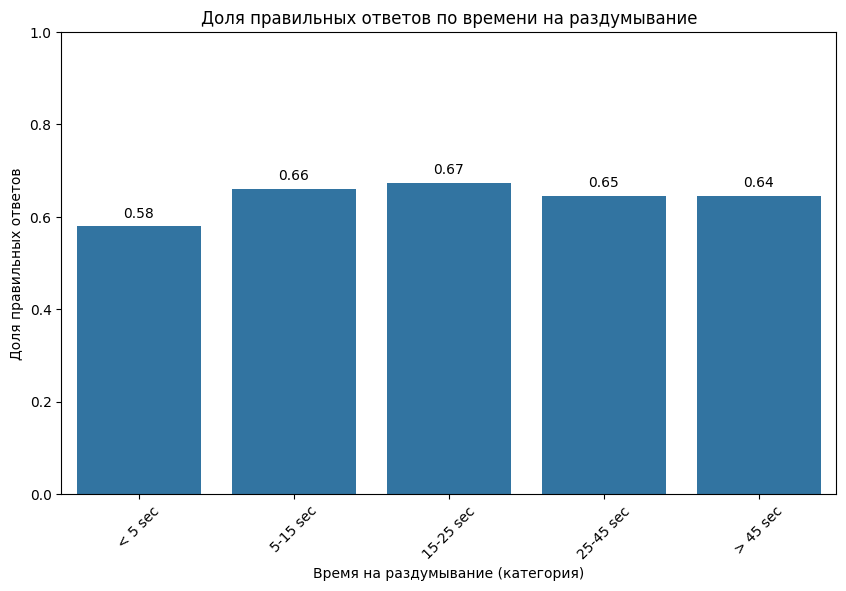

In [49]:
# Строим диаграмму
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=correctness_by_time.index, y=correctness_by_time.values)

# Добавляем заголовки и подписи осей
plt.title('Доля правильных ответов по времени на раздумывание')
plt.xlabel('Время на раздумывание (категория)')
plt.ylabel('Доля правильных ответов')
plt.ylim(0, 1)  # Ограничиваем ось Y от 0 до 1
plt.xticks(rotation=45)

# Подписываем значения над столбцами
for p in ax.patches:
    height = p.get_height()  # Высота каждого столбца
    ax.text(
        p.get_x() + p.get_width() / 2.,  # X-позиция текста (середина столбца)
        height + 0.02,  # Y-позиция текста (чуть выше столбца)
        f'{height:.2f}',  # Текст (доля правильных ответов с двумя знаками после запятой)
        ha="center"  # Выравнивание по центру
    )

# Показываем диаграмму
plt.show()

<u>Вывод:</u> Сильной зависимости между временем на ответ и правильностью ответа нет. Можно сказать, что данный признак не влияет на успеваемость студентов.

##### <u>4*. Анализ распределения правильных ответов по числу студентов.  *(Не анализирует успеваемость, но показывает интересную картину распределения данных)</u>


In [45]:
# Группируем данные по пользователям и считаем долю правильных ответов для каждого пользователя
user_correctness = sample_df.groupby('user_id')['answered_correctly'].mean()

# Фильтруем доли правильных ответов, оставляя только положительные значения
user_correctness_filtered = user_correctness[user_correctness >= 0]

# Подсчитываем общее количество пользователей
total_users = len(user_correctness_filtered)

# Подсчитываем частоты в интервалах
bins = pd.cut(user_correctness_filtered, bins=15)  # Определяем 15 интервалов
frequency = bins.value_counts().sort_index()

# Подсчитываем относительные частоты
relative_frequency = frequency / total_users
relative_frequency


answered_correctly
(-0.001, 0.0667]    0.133037
(0.0667, 0.133]     0.002229
(0.133, 0.2]        0.022105
(0.2, 0.267]        0.030615
(0.267, 0.333]      0.068269
(0.333, 0.4]        0.037010
(0.4, 0.467]        0.034110
(0.467, 0.533]      0.146715
(0.533, 0.6]        0.091839
(0.6, 0.667]        0.129795
(0.667, 0.733]      0.066088
(0.733, 0.8]        0.080838
(0.8, 0.867]        0.026836
(0.867, 0.933]      0.010028
(0.933, 1.0]        0.120486
Name: count, dtype: float64

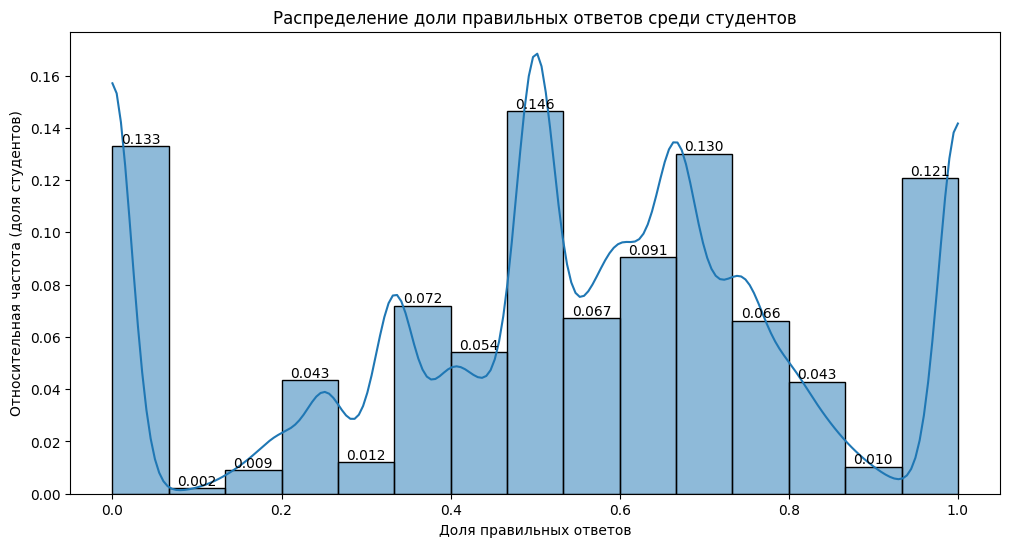

In [48]:
# Фильтруем доли правильных ответов, оставляя только положительные значения
user_correctness_filtered = user_correctness[user_correctness >= 0]

# Построение гистограммы с относительными частотами для отфильтрованных данных
plt.figure(figsize=(12, 6))
ax = sns.histplot(user_correctness_filtered, bins=15, kde=True, stat="probability")

# Добавляем значения частот поверх столбцов
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Подписываем только столбцы с ненулевыми значениями
        ax.text(p.get_x() + p.get_width() / 2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.title('Распределение доли правильных ответов среди студентов')
plt.xlabel('Доля правильных ответов')
plt.ylabel('Относительная частота (доля студентов)')
plt.show()